In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Data

See other notebooks for details about data preparation.

In [4]:
df = pd.read_pickle('fulldataframe.pkl')

In [5]:
standard_features = ['date', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 'HomesSold']

la_df = df[['LosAngelesCA', 'LosAngelesUnemployment'] + standard_features]
la_df.set_index('date', inplace=True)

In [6]:
sample_df = la_df # opt. replace with selection of columns

In [7]:
data = sample_df.diff().dropna()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data.values)
scaled_values = scaler.transform(data.values) * 1000 
# Note: we multiply by 1000 so that our minimal noise implementation can be stably estimated with noise std of 1

data = pd.DataFrame(scaled_values, index=data.index, columns=data.columns)
data.head(10)

LosAngelesCA  LosAngelesUnemployment  MORTGAGE30US    MedianCPI  \
date                                                                          
2000-02-29   -299.176188                4.901749    290.540216   742.456539   
2000-03-31   -227.898885                4.901749   -324.872412 -1363.216370   
2000-04-30    -29.328293                4.901749   -412.788501   677.552599   
2000-05-31     -3.314679                4.901749   2180.736144   335.591288   
2000-06-30    -26.380084             -129.406168  -1731.529846   341.331454   
2000-07-31    -15.107517                4.901749   -368.830456  -674.560880   
2000-08-31      5.356526             -129.406168   -588.620681   221.497504   
2000-09-30    -17.015182             -129.406168   -456.746546  -445.103949   
2000-10-31    -54.127939                4.901749   -852.368950   -66.608456   
2000-11-30    -83.089763             -129.406168    246.582171   758.461515   

            HomesForSale    HomesSold  
date                                   
2000-02-29   -992.946793  1679.831516  
2000-03-31   2390.976358  1528.176216  
2000-04-30  -2008.123738 -1504.929784  
2000-05-31   1375.799412  -140.032084  
2000-06-30     22.230152  -898.308584  
2000-07-31   -316.162163   769.899716  
2000-08-31    699.014782  -443.342684  
2000-09-30     22.230152  -443.342684  
2000-10-31    360.622467   163.278516  
2000-11-30   1375.799412 -1201.619184

# Frequentist VAR

We will verify our implementation of BVAR by comparing it to the frequentist VAR implemented in statsmodels.

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [10]:
model = VAR(data)

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [11]:
results=model.fit(maxlags=2)

In [12]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Feb, 2023
Time:                     18:13:29
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    80.9733
Nobs:                     272.000    HQIC:                   80.3544
Log likelihood:          -13109.4    FPE:                5.21629e+34
AIC:                      79.9392    Det(Omega_mle):     3.94190e+34
--------------------------------------------------------------------
Results for equation LosAngelesCA
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -1.690553        20.951533           -0.081           0.936
L1.LosAngelesCA                   1.168216         0.058647           19.919           0.000
L1.Lo

# Bayesian VAR

In [13]:
class BVAR:
    def __init__(self, df, lags=1, intercept_mean = 0, intercept_std = 5, 
                 lag_mean=0, lag_std=10, noise_std=5, minimal_noise = False):
        self.data = df
        self.trace = None
        self.minimal_noise = minimal_noise
        
        coords = {
            "lags": reversed(range(-lags, 0)),
            "vars": list(df.columns),
            "cross_vars": list(df.columns),
            "time": range(len(df) - lags),
        }
        
        self.model = pm.Model(coords=coords)
        
        with self.model:
            # Define priors for intercepts, lag coefficients, and noise if using
            intercept = pm.Normal("intercept", mu=intercept_mean, sigma=intercept_std, dims=("vars",))
            lag_coefs = pm.Normal("lag_coefs", mu=lag_mean, sigma=lag_std, dims=("lags", "vars", "cross_vars"))
            if minimal_noise is True:
                noise = 1
            else:
                noise = pm.HalfNormal("noise", sigma=noise_std, dims=("vars",))

            # Define priors for autoregression expectations
            ar_terms = []

            for j in range(len(df.columns)):
                # for each variable, convolve its matrix of lag coefficients over the dataframe
                # inner sum sums across variables, outer sum sums across lags
                ar = pm.math.sum([
                    pm.math.sum(lag_coefs[i, j] * df.values[lags-(i+1): -(i+1)], axis=1)
                    for i in range(lags)
                ], axis=0)
                ar_terms.append(ar)

            # Add intercept terms to autoregression expectations
            mean = intercept + pm.math.stack([ar for ar in ar_terms], axis=-1)

            # Define our observed stochastic variable. Restrict to observations that have lags available.
            obs = pm.Normal("obs", mu=mean, sigma=noise, observed=df[lags:], dims=("time", "vars"))
            
            self.prior_checks = pm.sample_prior_predictive(samples=50)
    
    def fit(self, draws=1000, tune=1000, chains=4, random_seed=None):
        with self.model:
            self.trace = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=random_seed, 
                                   idata_kwargs={"log_likelihood": True})
            
    def get_trace(self):
        if self.trace is not None:
            return self.trace
        else:
            raise Exception('Model not fitted. Fit model before proceeding.')
            
    def _forecast_single(self, df, intercept, lag_coefs, noise, horizon, rng):
        num_lags = len(lag_coefs.coords['lags'])
        df = df.copy() # assume we may need this to prevent issues. TODO: determine if needed

        # Extend the horizon of the time series data, filling future values with NaN defaults
        df = df.reindex(df.index.union(df.index.shift(horizon, 'M')))
        
        # Reverse the direction of lags to line up corretly with timesteps
        lag_coefs = lag_coefs.reindex(lags=list(reversed(lag_coefs.lags)))

        for t in range(-1 * horizon, 0):
            lagslice = df[t - num_lags:t or None].values # "or None" ensures last iteration does not return empty list
            var_means = np.sum(lag_coefs * lagslice, axis=(-1, -2)) # broadcast lags to timesteps and cross-vars to vars
            var_vals = intercept + var_means + rng.normal(0, noise, size=(var_means.shape))
            df.iloc[t] = var_vals

        return df
        
    def forecast(self, df=None, trace=None, horizon=1, draws=100, use_mean_parameters=False, rng=np.random.default_rng()):
        if df is None:
            df = self.data
            
        if trace is None:
            trace = self.get_trace()
        
        post = trace.posterior.stack(sample=("chain", "draw"))
        post = post.transpose('sample', 'vars', 'lags', 'cross_vars') # reorder dims for indexing and broadcasting
        
        if use_mean_parameters is False:
            samples_length = post.dims['sample']
            random_idxs = rng.integers(samples_length, size=draws) 

            intercept_samples = post['intercept'].isel(sample=random_idxs)
            lag_coefs_samples = post['lag_coefs'].isel(sample=random_idxs)
            if self.minimal_noise is False:
                noise_samples = post['noise'].isel(sample=random_idxs) 
            else:
                noise_samples = np.ones(shape=(intercept_samples.shape[0],))

            return [self._forecast_single(df, intercept_samples[i], lag_coefs_samples[i], noise_samples[i], horizon, rng) 
                    for i in range(draws)]
        else:
            intercept_mean = post['intercept'].mean(axis=0)
            lag_coefs_mean = post['lag_coefs'].mean(axis=0)
            noise_mean = 1 if self.minimal_noise else post['noise'].mean(axis=0)
            return [self._forecast_single(df, intercept_mean, lag_coefs_mean, noise_mean, horizon, rng)
                   for i in range(draws)]
    
    def summary(self):
        if self.trace is None:
            raise Exception('Model not fitted. Fit model before proceeding.')
        
        return az.summary(self.trace)
    
    def plot_trace(self):
        if self.trace is None:
            raise Exception('Model not fitted. fit model before proceeding.')
        az.plot_trace(self.trace, compact=False)
        

In [14]:
BVAR_model = BVAR(data, lags=2)
BVAR_model.fit(random_seed=rng)

Sampling: [intercept, lag_coefs, noise, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


## Fit examination

The below plots show the posterior distributions over the model's parameters. The naming convention  for lag coefficients uses a negative number to indicate the number of lags, then the dependent variable, then the independnet variable. For example: "-2, LosAngelesCA, LosAngelesUnemployment" is the label for the coefficient for how much LosAngelesCA is impacted by the value of LosAngelesUnemployment two timesteps prior.

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (84), generating only 20 plots
  warnings.warn(


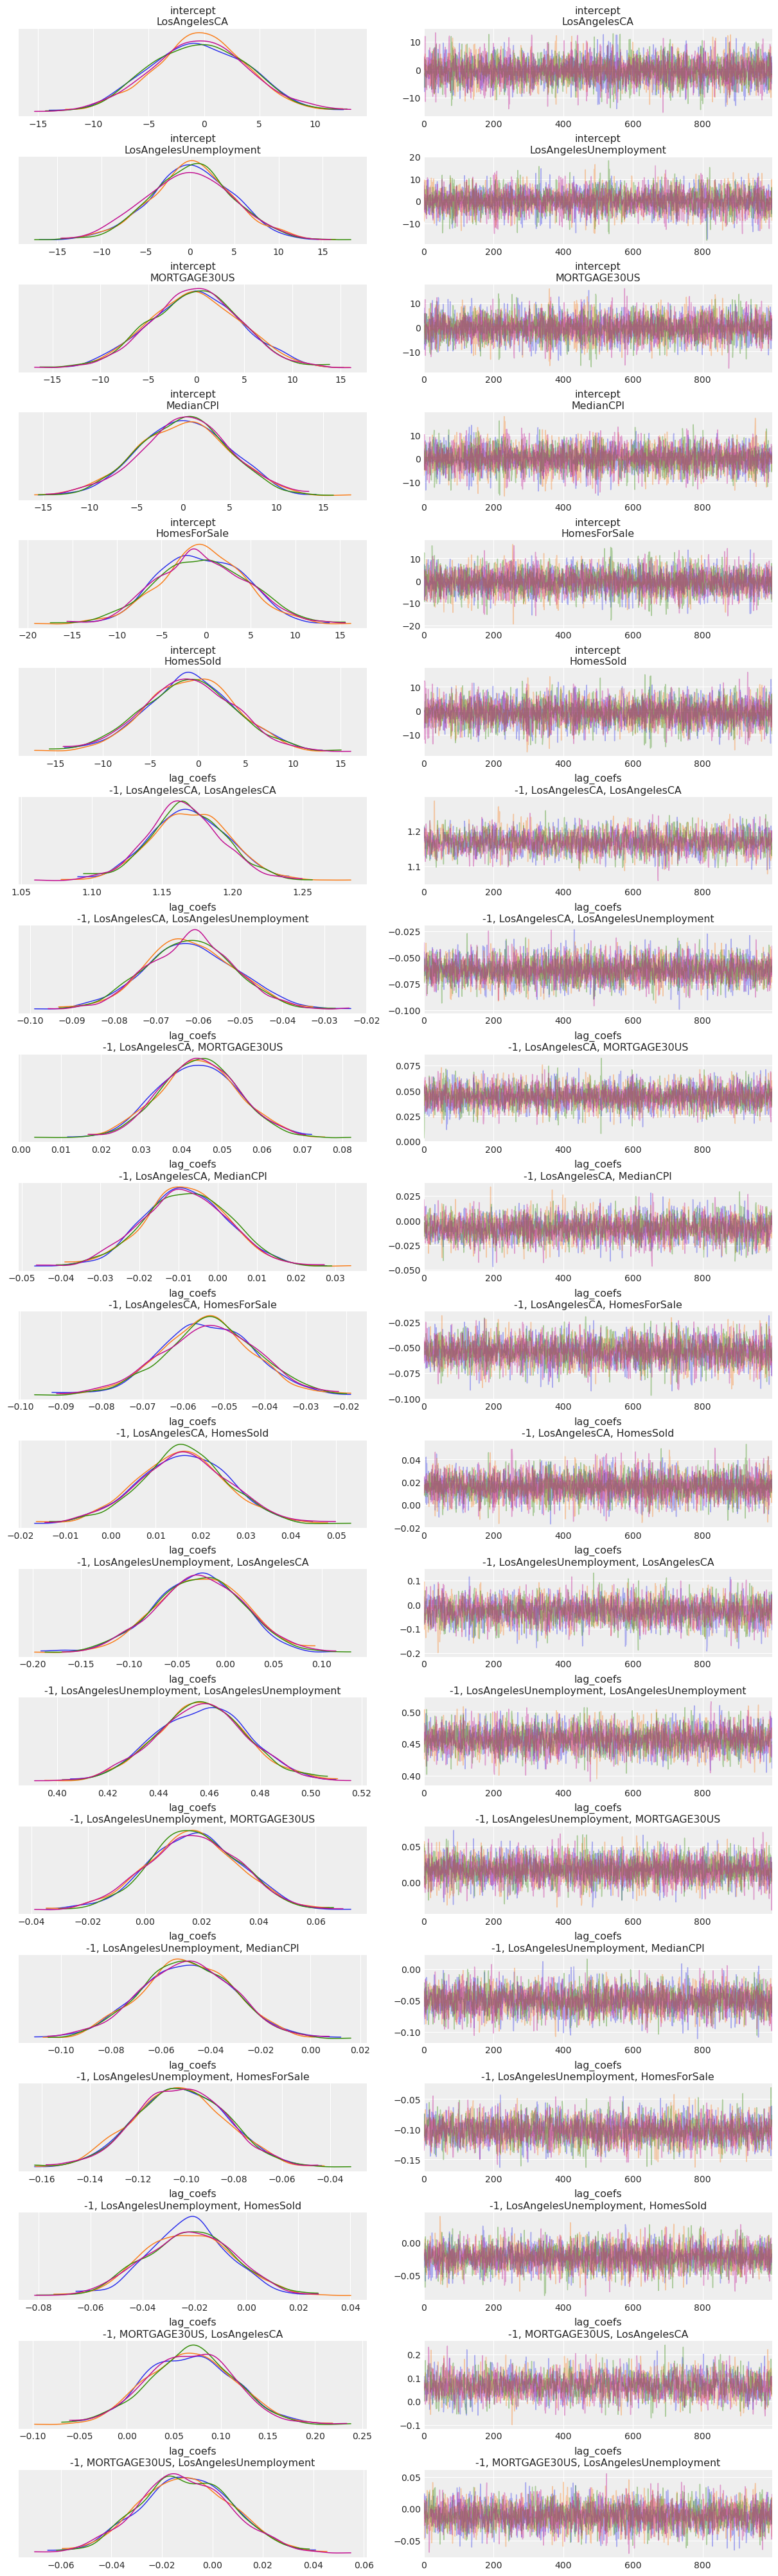

In [29]:
BVAR_model.plot_trace()

The below table summarizes the posterior distributions over the parameters. The coefficients for LosAngelesCA's dependence on LosAngelesUnemployment differ significantly from the frequentist estimation. We will show below that this is attributable to the inclusion of noise at the observation-level in our model.

In [16]:
display(BVAR_model.summary())

mean     sd   hdi_3%  hdi_97%  \
intercept[LosAngelesCA]             -0.388  4.455   -9.162    7.409   
intercept[LosAngelesUnemployment]    0.118  4.817   -8.586    9.783   
intercept[MORTGAGE30US]             -0.132  4.745   -9.060    8.688   
intercept[MedianCPI]                 0.124  4.886   -8.825    9.345   
intercept[HomesForSale]             -0.501  4.929   -9.386    8.891   
...                                    ...    ...      ...      ...   
noise[LosAngelesUnemployment]      266.017  2.372  261.668  270.554   
noise[MORTGAGE30US]                276.064  2.465  271.270  280.607   
noise[MedianCPI]                   259.248  2.421  254.942  264.029   
noise[HomesForSale]                244.329  2.402  239.680  248.782   
noise[HomesSold]                   274.715  2.485  269.548  278.956   

                                   mcse_mean  mcse_sd  ess_bulk  ess_tail  \
intercept[LosAngelesCA]                0.050    0.081    8003.0    2725.0   
intercept[LosAngelesUnemployment]      0.061    0.087    6229.0    2652.0   
intercept[MORTGAGE30US]                0.057    0.086    6840.0    2802.0   
intercept[MedianCPI]                   0.055    0.099    7901.0    2323.0   
intercept[HomesForSale]                0.058    0.092    7163.0    2696.0   
...                                      ...      ...       ...       ...   
noise[LosAngelesUnemployment]          0.027    0.019    7502.0    3011.0   
noise[MORTGAGE30US]                    0.031    0.022    6497.0    2810.0   
noise[MedianCPI]                       0.029    0.020    6940.0    3082.0   
noise[HomesForSale]                    0.030    0.021    6367.0    2836.0   
noise[HomesSold]                       0.031    0.022    6417.0    2945.0   

                                   r_hat  
intercept[LosAngelesCA]              1.0  
intercept[LosAngelesUnemployment]    1.0  
intercept[MORTGAGE30US]              1.0  
intercept[MedianCPI]                 1.0  
intercept[HomesForSale]              1.0  
...                                  ...  
noise[LosAngelesUnemployment]        1.0  
noise[MORTGAGE30US]                  1.0  
noise[MedianCPI]                     1.0  
noise[HomesForSale]                  1.0  
noise[HomesSold]                     1.0  

[84 rows x 9 columns]

## Noise Minimality Experiment and Verifying Parameter Estimation Implementation

The below experiment demonstrates that the difference between the above results and the frequentist estimation is due to the inclusion of sampling noise in the model. (For context, we must include sampling noise in the Bayesian model in order for the MCMC algorithm to work. See [this thread](https://discourse.pymc.io/t/observed-deterministic/483/10) for details. Instead of using no noise, our Bayesian model includes an option for minimal noise with standard deviation of 1 for the ZHVI variable and 0.1 for Mortgage variable. (TODO: note that these standard deviations were handcrafted for the respective variables to be small without causing divergencces. In the future, having it be calculated automatically based on the variable's standard deviation might be desirable.) The similarity of estimated parameters verifies our implementation of our BVAR model.

In [17]:
BVAR_minnoise = BVAR(data, lags=2, minimal_noise=True)
BVAR_minnoise.fit(random_seed=rng)
BVAR_minnoise.summary()

Sampling: [intercept, lag_coefs, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


mean     sd  hdi_3%  \
intercept[LosAngelesCA]                          -1.690  0.060  -1.806   
intercept[LosAngelesUnemployment]                 2.450  0.062   2.337   
intercept[MORTGAGE30US]                          -1.220  0.060  -1.336   
intercept[MedianCPI]                              0.941  0.061   0.826   
intercept[HomesForSale]                          -4.329  0.062  -4.455   
...                                                 ...    ...     ...   
lag_coefs[-2, HomesSold, LosAngelesUnemployment]  0.181  0.000   0.181   
lag_coefs[-2, HomesSold, MORTGAGE30US]           -0.050  0.000  -0.050   
lag_coefs[-2, HomesSold, MedianCPI]               0.065  0.000   0.065   
lag_coefs[-2, HomesSold, HomesForSale]            0.102  0.000   0.102   
lag_coefs[-2, HomesSold, HomesSold]               0.100  0.000   0.100   

                                                  hdi_97%  mcse_mean  mcse_sd  \
intercept[LosAngelesCA]                            -1.584      0.001    0.001   
intercept[LosAngelesUnemployment]                   2.573      0.001    0.001   
intercept[MORTGAGE30US]                            -1.107      0.001    0.000   
intercept[MedianCPI]                                1.054      0.001    0.001   
intercept[HomesForSale]                            -4.219      0.001    0.001   
...                                                   ...        ...      ...   
lag_coefs[-2, HomesSold, LosAngelesUnemployment]    0.181      0.000    0.000   
lag_coefs[-2, HomesSold, MORTGAGE30US]             -0.050      0.000    0.000   
lag_coefs[-2, HomesSold, MedianCPI]                 0.065      0.000    0.000   
lag_coefs[-2, HomesSold, HomesForSale]              0.102      0.000    0.000   
lag_coefs[-2, HomesSold, HomesSold]                 0.100      0.000    0.000   

                                                  ess_bulk  ess_tail  r_hat  
intercept[LosAngelesCA]                             6652.0    2926.0    1.0  
intercept[LosAngelesUnemployment]                   5905.0    2941.0    1.0  
intercept[MORTGAGE30US]                             7559.0    2882.0    1.0  
intercept[MedianCPI]                                6857.0    3275.0    1.0  
intercept[HomesForSale]                             5287.0    2771.0    1.0  
...                                                    ...       ...    ...  
lag_coefs[-2, HomesSold, LosAngelesUnemployment]    4571.0    3044.0    1.0  
lag_coefs[-2, HomesSold, MORTGAGE30US]              6002.0    2899.0    1.0  
lag_coefs[-2, HomesSold, MedianCPI]                 4976.0    3070.0    1.0  
lag_coefs[-2, HomesSold, HomesForSale]              5368.0    3687.0    1.0  
lag_coefs[-2, HomesSold, HomesSold]                 7176.0    3377.0    1.0  

[78 rows x 9 columns]

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (78), generating only 20 plots
  warnings.warn(


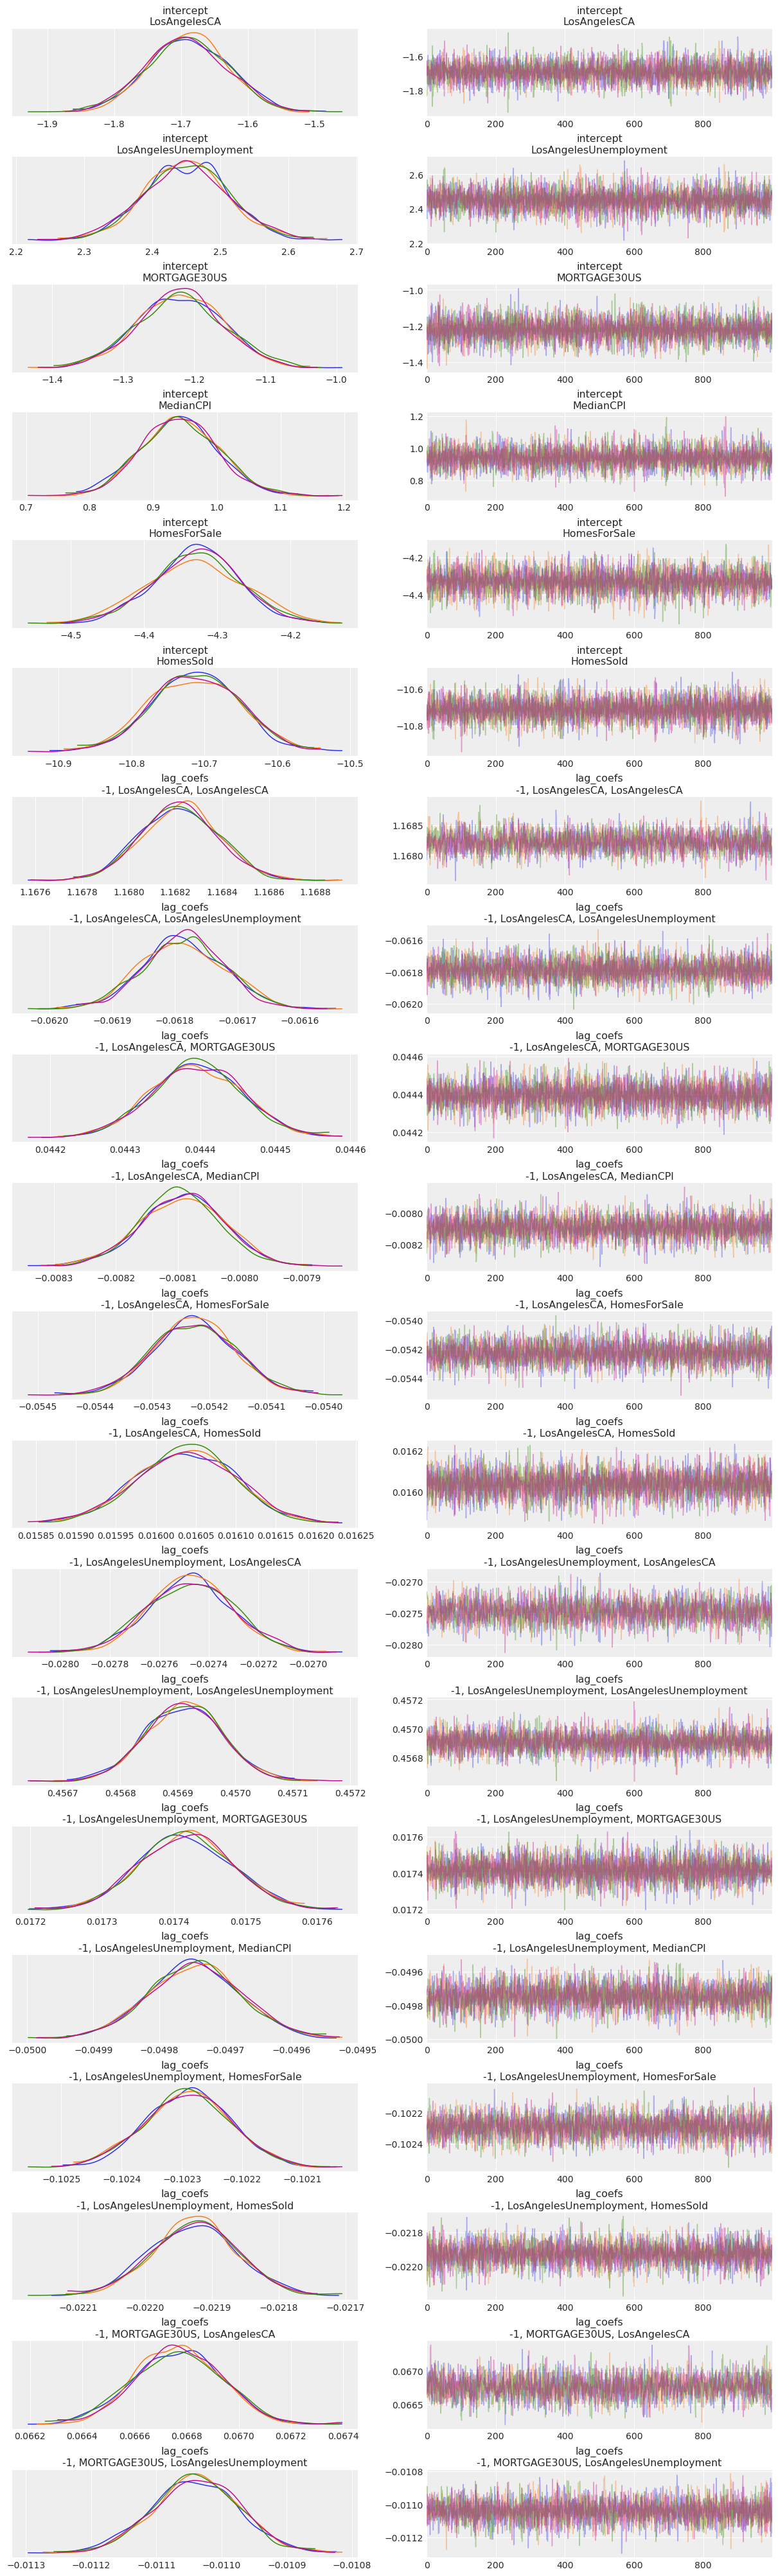

In [31]:
BVAR_minnoise.plot_trace()

## Forecasting

We can verify our implementation of forecasting by comparing the minimal-noise model with mean parameter estimates to the statsmodels implementation.

In [19]:
results.forecast(data.to_numpy(), 1)

array([[-1200.45204853,   269.06391787,  -638.35643352,   167.68779242,
          427.01725231,    21.36039668]])

In [20]:
BVAR_minnoise.forecast(horizon=1, use_mean_parameters=True, draws=1)[0].iloc[-1:,]

LosAngelesCA  LosAngelesUnemployment  MORTGAGE30US   MedianCPI  \
date                                                                         
2022-12-31  -1201.199995              269.166838   -637.652129  166.316652   

            HomesForSale  HomesSold  
date                                 
2022-12-31    428.296833   22.14049

The below graphs reflect the forecasts produced by the standard BVAR and minimal-noise BVAR models using both parameter distributions and mean parameter estimations.

In [21]:
def invert_transformation(startpoint, raw_differences):
    raw_differences = raw_differences / 1000
    differences = pd.DataFrame(scaler.inverse_transform(raw_differences.values), 
                               index=raw_differences.index, columns=raw_differences.columns)
    return startpoint + differences.cumsum()

In [38]:
def plot_draws(draws):
    _, ax = plt.subplots(2, 1, sharex=True)
    ax[0].set_title("ZHVI with Forecast")
    ax[1].set_title("Unemployment with Forecast")

    for draw in draws:
        forecast = invert_transformation(sample_df.iloc[0], draw)
        ax[0].plot(draw.index, forecast.iloc[:,0], color="C0", alpha=0.05)
        ax[1].plot(draw.index, forecast.iloc[:, 1], color="C1", alpha=0.05)

    ax[0].plot(data.index, sample_df.iloc[1:,0], color="black")
    ax[1].plot(data.index, sample_df.iloc[1:,1], color="black")

Forecasting with parameter distributions and observation noise


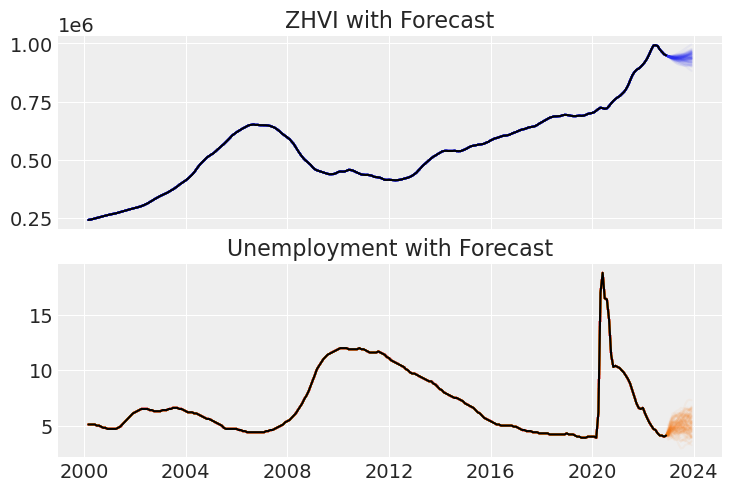

In [39]:
forecast_draws_distribution = BVAR_model.forecast(horizon=12)
print("Forecasting with parameter distributions and observation noise")
plot_draws(forecast_draws_distribution)

Forecasting with mean parameter estimates and observation noise


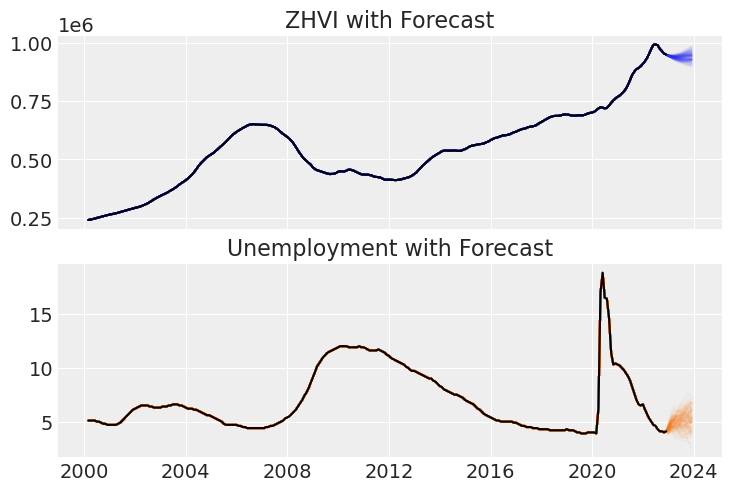

In [40]:
forecast_draws_mean = BVAR_model.forecast(horizon=12, use_mean_parameters=True)
print("Forecasting with mean parameter estimates and observation noise")
plot_draws(forecast_draws_mean)

Forecasting with parameter distributions and minimal noise


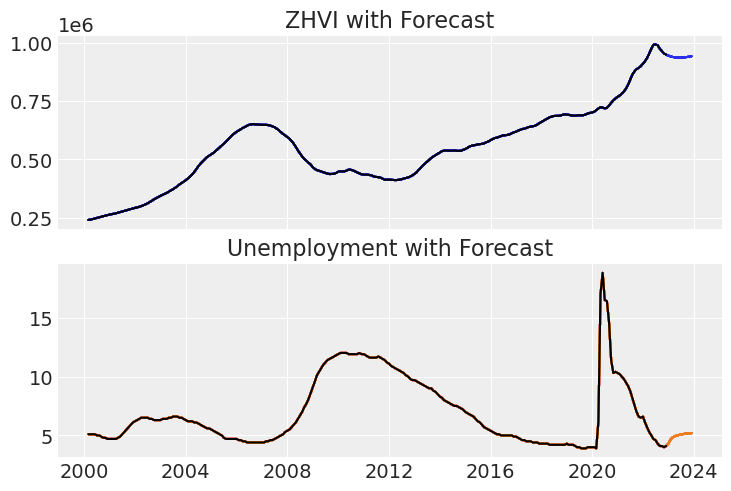

In [41]:
forecast_draws_minnoise = BVAR_minnoise.forecast(horizon=12)
print("Forecasting with parameter distributions and minimal noise")
plot_draws(forecast_draws_minnoise)

Forecasting with mean parameter estimates and minimal noise


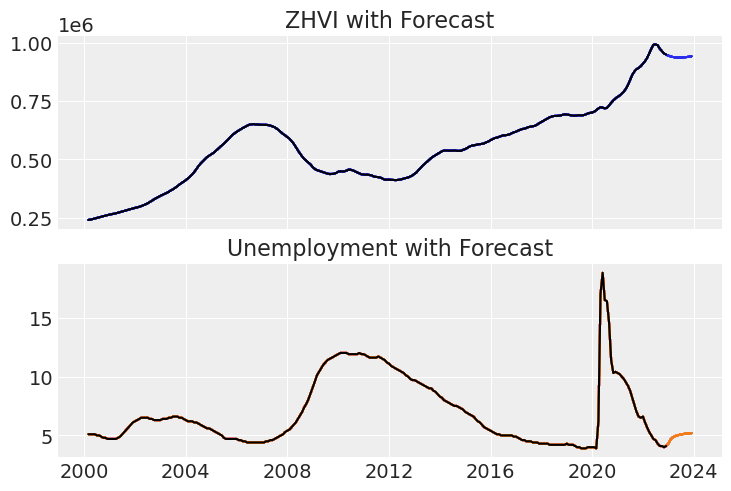

In [42]:
forecast_draws_mean_minnoise = BVAR_minnoise.forecast(horizon=12, use_mean_parameters=True)
print("Forecasting with mean parameter estimates and minimal noise")
plot_draws(forecast_draws_mean_minnoise)

## Bayesian Model Evaluation

We will evaluate our models in the first instance using posterior predictive checks. If our model is working well, then the observed data will fall neatly within the range of posterior predictive samples. We will focus on the posterior predictive check with respect to the ZHVI variable.

Sampling: [obs]


<AxesSubplot: xlabel='obs / obs'>

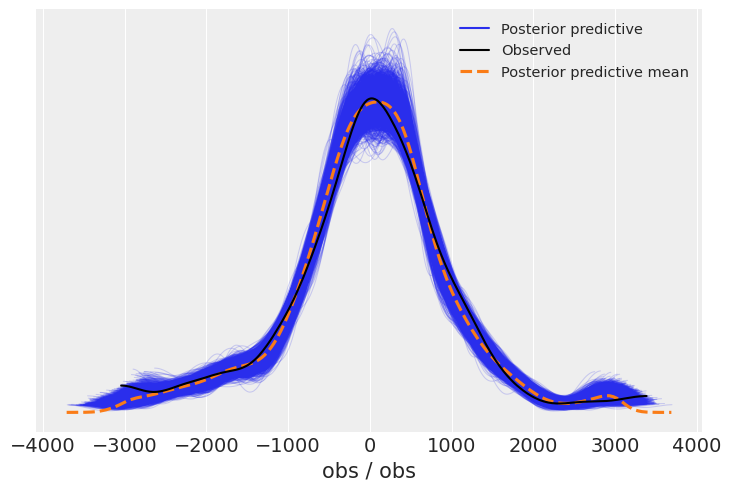

In [27]:
with BVAR_model.model:
    ppc = pm.sample_posterior_predictive(BVAR_model.trace, random_seed=RANDOM_SEED)
az.plot_ppc(ppc.sel(vars="LosAngelesCA"))

Sampling: [obs]


<AxesSubplot: xlabel='obs / obs'>

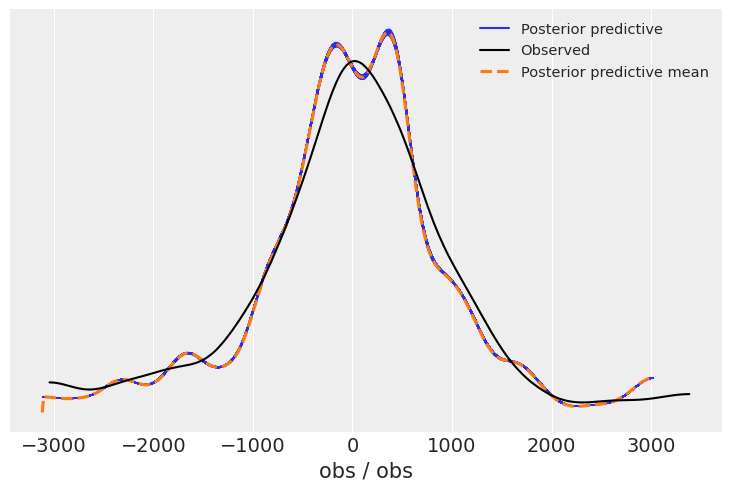

In [28]:
with BVAR_minnoise.model:
    ppc = pm.sample_posterior_predictive(BVAR_minnoise.trace, random_seed=RANDOM_SEED)
az.plot_ppc(ppc.sel(vars="LosAngelesCA"))

Clearly, the model that uses noise is doing a better job of retrodicting the data.

Since the mean parameter estimates of the minimal-noise model agree so closely with the frequentist VAR model, it would not be very informative to compare the two models on the basis of point predictions generated by mean parameter estimates. The strength of the Bayesian approach comes from being able to generate prediction distributions rather than just point predictions. This leads to using metrics other than, for example, R<sup>2</sup> to compare models. We will compare the minimal-noise and non-minimal-noise Bayesian models using a measure called Expected Log Pointwise Predictive Density (ELPD) (see [this link](https://bayesiancomputationbook.com/markdown/chp_02.html#cross-validation-and-loo) for details) and time-series cross validation. The ELPD measure is the sum of the log-probabilities of test datapoints integrated over the posterior distribution of the posterior parameter distributions. (Note: computation unintensive measures such as arviz.loo are not usable here due to the specific nature of time series cross validation.) 

TODO: this

## Comparison with restricted model

However, we should also compare these models with the restricted model that uses only one variable.

In [47]:
data_restricted = data[['LosAngelesCA']]

In [50]:
BVAR_restricted = BVAR(data_restricted, lags=2)
BVAR_restricted.fit(random_seed=rng)

Sampling: [intercept, lag_coefs, noise, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [52]:
BVAR_restricted.summary()

mean     sd   hdi_3%  hdi_97%  \
intercept[LosAngelesCA]                     -0.440  4.553   -8.616    8.473   
lag_coefs[-1, LosAngelesCA, LosAngelesCA]    1.199  0.027    1.149    1.250   
lag_coefs[-2, LosAngelesCA, LosAngelesCA]   -0.295  0.027   -0.347   -0.245   
noise[LosAngelesCA]                        164.179  2.357  159.857  168.436   

                                           mcse_mean  mcse_sd  ess_bulk  \
intercept[LosAngelesCA]                        0.080    0.073    3268.0   
lag_coefs[-1, LosAngelesCA, LosAngelesCA]      0.001    0.000    1704.0   
lag_coefs[-2, LosAngelesCA, LosAngelesCA]      0.001    0.000    1729.0   
noise[LosAngelesCA]                            0.040    0.028    3427.0   

                                           ess_tail  r_hat  
intercept[LosAngelesCA]                      2657.0    1.0  
lag_coefs[-1, LosAngelesCA, LosAngelesCA]    2218.0    1.0  
lag_coefs[-2, LosAngelesCA, LosAngelesCA]    2075.0    1.0  
noise[LosAngelesCA]                          2755.0    1.0

Sampling: [obs]


<AxesSubplot: xlabel='obs / obs'>

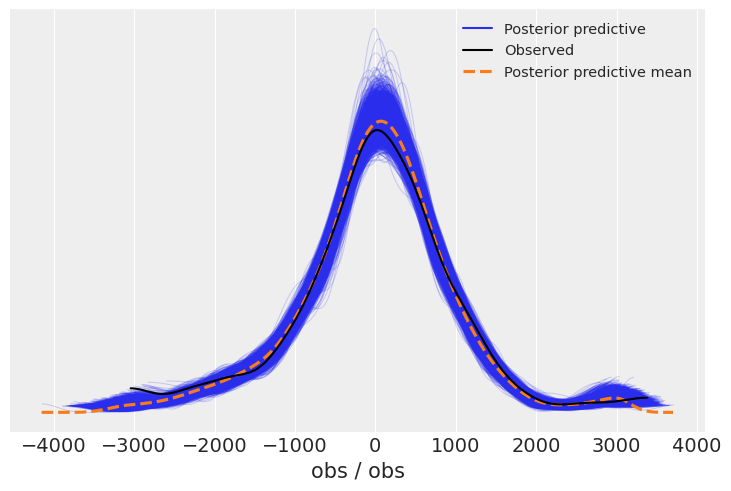

In [53]:
with BVAR_restricted.model:
    ppc = pm.sample_posterior_predictive(BVAR_restricted.trace, random_seed=RANDOM_SEED)
az.plot_ppc(ppc.sel(vars="LosAngelesCA"))